<a href="https://colab.research.google.com/github/Lucymaha/ML-Project-Heart-Disease-Prediction/blob/main/AI_Extra_Credit_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time

In [2]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data',
train=True,
download=True,
transform=transform)
valid_dataset = datasets.MNIST(root='./data',
train=True,
transform=transform)
test_dataset = datasets.MNIST(root='./data',
train=False,
transform=transform)

100%|██████████| 9912422/9912422 [04:28<00:00, 36985.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2590860.74it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:46<00:00, 35087.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13138295.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
validation_fraction = 0.1

In [5]:
num = int(validation_fraction * 60000)
train_indices = torch.arange(0, 60000 - num)
valid_indices = torch.arange(60000 - num, 60000)

In [6]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [7]:
train_loader = DataLoader(dataset=train_dataset,
batch_size=BATCH_SIZE,
drop_last=True,
sampler=train_sampler)
valid_loader = DataLoader(dataset=valid_dataset,
batch_size=BATCH_SIZE,
sampler=valid_sampler)
test_loader = DataLoader(dataset=test_dataset,
batch_size=BATCH_SIZE,
shuffle=False)

In [49]:
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


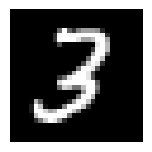

In [51]:
import matplotlib.pyplot as plt
# Display a grid of sample images
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_loader):
    for j in range(25):
        plt.subplot(5, 5, j + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.axis('off')
        break
plt.show()

In [41]:
class MLP(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, num_hidden_1),
            nn.BatchNorm1d(num_hidden_1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_hidden_1, num_hidden_2),
            nn.BatchNorm1d(num_hidden_2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(num_hidden_2, num_classes)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits




In [42]:
model = MLP(num_features=28*28,
num_hidden_1=128,
num_hidden_2=64,
num_classes=10)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
factor=0.1,
mode='min')

In [52]:
# Define your optimizer (using Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
# Create the scheduler with step decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [56]:
# Create the scheduler with exponential decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [43]:

def compute_accuracy(data_loader, model, DEVICE):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)  # Ensure targets are on the same device as features
            # Assuming your model outputs logits directly (no softmax applied)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().item()  # Convert to Python scalar
        return correct_pred / num_examples * 100


In [45]:
# Now let's put everything together
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        logits = model(features)
        loss = criterion(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        minibatch_loss_list.append(loss.item())
        logging_interval = 100
        if not batch_idx % logging_interval:
            print("Epoch: ", epoch+1,"/", NUM_EPOCHS,"| Batch ",batch_idx,"/",len(train_loader), f'| Loss: {loss:.4f}')

    model.eval()
    with torch.no_grad(): # save memory during inference
        train_acc = compute_accuracy(train_loader, model, DEVICE)
        valid_acc = compute_accuracy(valid_loader, model, DEVICE)
        print("Epoch: ", epoch+1, "/",NUM_EPOCHS,
              f'| Train: {train_acc :.2f}% '
              f'| Validation: {valid_acc :.2f}%')
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

    elapsed = (time.time() - start_time)/60
    print("Time elapsed: ",elapsed, " min")
    scheduler.step(minibatch_loss_list[-1])

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')
test_acc = compute_accuracy(test_loader, model, DEVICE)
print(f'Test accuracy {test_acc :.2f}%')


Epoch:  1 / 20 | Batch  0 / 843 | Loss: 0.0688
Epoch:  1 / 20 | Batch  100 / 843 | Loss: 0.3262
Epoch:  1 / 20 | Batch  200 / 843 | Loss: 0.2334
Epoch:  1 / 20 | Batch  300 / 843 | Loss: 0.4546
Epoch:  1 / 20 | Batch  400 / 843 | Loss: 0.3093
Epoch:  1 / 20 | Batch  500 / 843 | Loss: 0.2941
Epoch:  1 / 20 | Batch  600 / 843 | Loss: 0.2020
Epoch:  1 / 20 | Batch  700 / 843 | Loss: 0.2686
Epoch:  1 / 20 | Batch  800 / 843 | Loss: 0.2926
Epoch:  1 / 20 | Train: 96.25% | Validation: 97.03%
Time elapsed:  0.5842756986618042  min
Epoch:  2 / 20 | Batch  0 / 843 | Loss: 0.2898
Epoch:  2 / 20 | Batch  100 / 843 | Loss: 0.4680
Epoch:  2 / 20 | Batch  200 / 843 | Loss: 0.2228
Epoch:  2 / 20 | Batch  300 / 843 | Loss: 0.2091
Epoch:  2 / 20 | Batch  400 / 843 | Loss: 0.4837
Epoch:  2 / 20 | Batch  500 / 843 | Loss: 0.1566
Epoch:  2 / 20 | Batch  600 / 843 | Loss: 0.2219
Epoch:  2 / 20 | Batch  700 / 843 | Loss: 0.2755
Epoch:  2 / 20 | Batch  800 / 843 | Loss: 0.0774
Epoch:  2 / 20 | Train: 96.87% 

Text(0, 0.5, 'Loss')

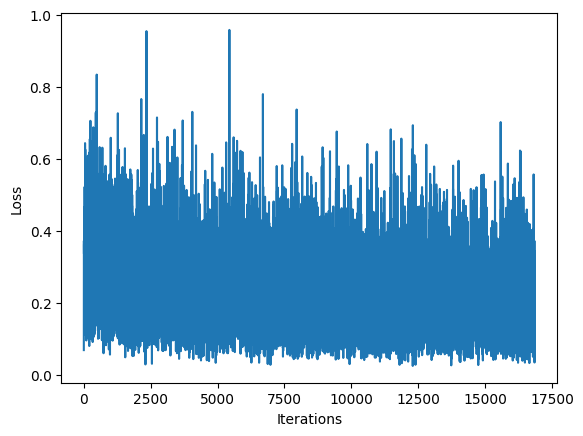

In [57]:
import matplotlib.pyplot as plt
plt.plot(range(len(minibatch_loss_list)), minibatch_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')

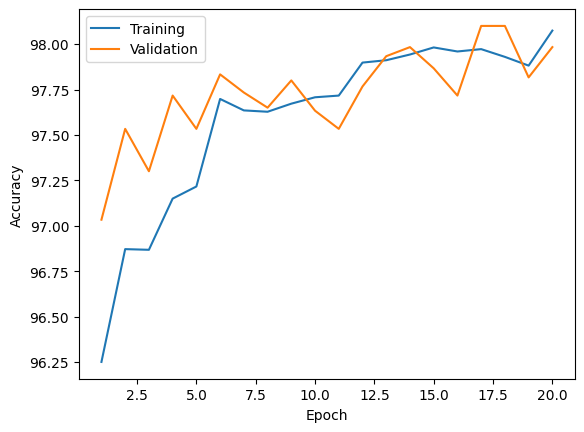

In [47]:
import numpy as np
import matplotlib.pyplot as plt

num_epochs = len(train_acc_list)
plt.plot(np.arange(1, num_epochs+1), train_acc_list, label='Training')
plt.plot(np.arange(1, num_epochs+1), valid_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
